In [267]:
import os
import sys

from tqdm import tqdm
import numpy as np
import scipy as sp
import pandas as pd
from pykalman import KalmanFilter
import torch
from torch import nn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import DBSCAN
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta, time

In [192]:
path = "./data/df_hack_final.csv"

In [237]:
df = pd.read_csv(path)
df['MEAS_DT'] = pd.to_datetime(df['MEAS_DT'])

In [238]:
drop_columns = [col for col in df.columns if col[8:11] in ['max', 'min']]
df = df.drop(drop_columns, axis=1)

In [239]:
df.where(df[['Dens_1']] > 1.1, other=np.nan, inplace=True)
df.where(df[['Ni_rec']] != 1, other=np.nan, inplace=True)

In [240]:
def create_step_dataset(df, times_dict, target_list):
    # 6 float
    df_list = []
    total_step = (sum(times_dict.values()) - times_dict[3]) // 15
    df_rec = df[['Ni_rec', 'Ni_resth', 'Cu_resth']][total_step:]
    df_list.append(df_rec)
    # 0
    columns_feed_1 = ['Dens_1', 'Ni_oreth', 'Cu_oreth']
    df_list.append(df[columns_feed_1][:-total_step])
    # 1 
    step_1 = times_dict[1] // 15
    columns_1 = [col for col in df.columns if (col[3] == '1') & (col[4] != 'F')]
    df_list.append(df[columns_1][step_1:-total_step + step_1])
    columns_feed_2 = [col for col in df.columns if (col[3] == '2') & (col[4] == 'F')]
    columns_feed_2.append('Dens_2')
    df_list.append(df[columns_feed_2][step_1:-total_step + step_1])
    # 2
    step_2 = step_1 + times_dict[2] // 15
    columns_2 = [col for col in df.columns if (col[3] == '2') & (col[4] != 'F')]
    df_list.append(df[columns_2][step_2:-total_step + step_2])
    columns_feed_3 = [col for col in df.columns if (col[3] == '3') & (col[4] == 'F')]
    columns_feed_3.append('Dens_3')
    df_list.append(df[columns_feed_3][step_2:-total_step + step_2])
    columns_feed_4 = [col for col in df.columns if (col[3] == '4') & (col[4] == 'F')]
    columns_feed_4.append('Dens_4')
    df_list.append(df[columns_feed_4][step_2:-total_step + step_2])
    # 3
    step_3 = step_2 + times_dict[3] // 15
    columns_3 = [col for col in df.columns if (col[3] == '3') & (col[4] != 'F')]
    df_list.append(df[columns_3][step_3:-total_step + step_3])
    # 4
    step_4 = step_2 + times_dict[4] // 15
    columns_4 = [col for col in df.columns if (col[3] == '4') & (col[4] != 'F')]
    df_list.append(df[columns_4][step_4:-total_step + step_4])
    columns_feed_5 = [col for col in df.columns if (col[3] == '5') & (col[4] == 'F')]
    columns_feed_5.append('Dens_5')
    df_list.append(df[columns_feed_5][step_4:-total_step + step_4])
    # 5
    step_5 = step_4 + times_dict[5] // 15
    columns_5 = [col for col in df.columns if (col[3] == '5') & (col[4] != 'F')]
    df_list.append(df[columns_5][step_5:-total_step + step_5])
    columns_feed_6 = [col for col in df.columns if (col[3] == '6') & (col[4] == 'F')]
    columns_feed_6.append('Dens_6')
    df_list.append(df[columns_feed_6][step_5:-total_step + step_5])
    # 6
    step_6 = step_5 + times_dict[6] // 15
    columns_6 = [col for col in df.columns if (col[3] == '6') & (col[4] != 'F')]
    df_list.append(df[columns_6][step_6:])
    
    full_dataset = pd.concat(df_list, axis=1)
    # full_dataset = full_dataset[~full_dataset[target_list].isna().any(axis=1)]
    full_dataset = full_dataset.reset_index(drop=True)

    return full_dataset.drop(target_list, axis=1), full_dataset[target_list]

In [241]:
# times_dict = {
#     1: 60,
#     2: 60,
#     3: 60,
#     4: 60,
#     5: 60,
#     6: 60
# }

times_dict = {
    1: 60,
    2: 60,
    3: 60,
    4: 45,
    5: 30,
    6: 30,
}

target_list = [
    'Ni_1.1C', 'Cu_1.1C', 'Ni_1.2C', 'Cu_1.2C',
    'Cu_2.1T', 'Cu_2.2T', 
    'Cu_3.1T', 'Cu_3.2T',
    'Ni_4.1C', 'Ni_4.2C',
    'Ni_4.1T', 'Ni_4.2T',
    'Ni_5.1C', 'Ni_5.2C',
    'Ni_5.1T', 'Ni_5.2T',
    'Ni_6.1C', 'Ni_6.2C',
    'Ni_6.1T', 'Ni_6.2T',
]

In [242]:
# Ni_1.1C_min,Ni_1.1C_max,Cu_1.1C_min,Cu_1.1C_max,
# Ni_1.2C_min,Ni_1.2C_max,Cu_1.2C_min,Cu_1.2C_max,
# Cu_2.1T_min,Cu_2.1T_max,
# Cu_2.2T_min,Cu_2.2T_max,
# Cu_3.1T_min,Cu_3.1T_max,Cu_3.2T_min,Cu_3.2T_max,
# Ni_4.1T_min,Ni_4.1T_max,Ni_4.1C_min,Ni_4.1C_max,
# Ni_4.2T_min,Ni_4.2T_max,Ni_4.2C_min,Ni_4.2C_max,
# Ni_5.1T_min,Ni_5.1T_max,Ni_5.1C_min,Ni_5.1C_max,
# Ni_5.2T_min,Ni_5.2T_max,Ni_5.2C_min,Ni_5.2C_max,
# Ni_6.1T_min,Ni_6.1T_max,Ni_6.1C_min,Ni_6.1C_max,
# Ni_6.2T_min,Ni_6.2T_max,Ni_6.2C_min,Ni_6.2C_max

In [243]:
train_df, target_df = create_step_dataset(df, times_dict, target_list=target_list)

In [244]:
train_df.columns

Index(['Ni_rec', 'Ni_resth', 'Cu_resth', 'Dens_1', 'Ni_oreth', 'Cu_oreth',
       'FM_1.1_A', 'FM_1.2_A', 'Cu_2F', 'Ni_2F', 'Dens_2', 'Cu_2.1C',
       'Ni_2.1C', 'Cu_2.2C', 'Ni_2.2C', 'Ni_2.1T', 'Ni_2.2T', 'FM_2.1_A',
       'FM_2.2_A', 'Cu_3F', 'Ni_3F', 'Dens_3', 'Cu_4F', 'Ni_4F', 'Dens_4',
       'Cu_3.1C', 'Ni_3.1C', 'Cu_3.2C', 'Ni_3.2C', 'Ni_3.1T', 'Ni_3.2T',
       'FM_3.1_A', 'FM_3.2_A', 'FM_4.1_A', 'FM_4.2_A', 'Ni_5F', 'Dens_5',
       'FM_5.1_A', 'FM_5.2_A', 'Ni_6F', 'Dens_6', 'FM_6.1_A', 'FM_6.2_A'],
      dtype='object')

In [220]:
model = cb.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.02,
    depth=6,
    loss_function='MultiRMSEWithMissingValues',
    eval_metric='MultiRMSEWithMissingValues'
)

In [221]:
model.fit(train_df, target_df, verbose=False)

In [222]:
predictions = model.predict(train_df)
rmse = ((target_df - predictions) ** 2).mean(axis=0) ** 0.5
rmse

Ni_1.1C    0.161026
Cu_1.1C    0.106939
Ni_1.2C    0.137152
Cu_1.2C    0.182549
Cu_2.1T    0.018619
Cu_2.2T    0.018766
Cu_3.1T    0.353234
Cu_3.2T    0.206804
Ni_4.1C    0.103679
Ni_4.2C    0.097128
Ni_4.1T    0.021191
Ni_4.2T    0.039971
Ni_5.1C    0.117311
Ni_5.2C    0.201418
Ni_5.1T    0.026377
Ni_5.2T    0.027232
Ni_6.1C    0.109756
Ni_6.2C    0.072390
Ni_6.1T    0.050233
Ni_6.2T    0.085576
dtype: float64

In [223]:
predictions_df = pd.DataFrame(predictions, columns=target_df.columns)

In [224]:
predictions_df.mean()

Ni_1.1C    2.870278
Cu_1.1C    4.574911
Ni_1.2C    2.970488
Cu_1.2C    4.925297
Cu_2.1T    0.395274
Cu_2.2T    0.460302
Cu_3.1T    1.398516
Cu_3.2T    1.333379
Ni_4.1C    4.677618
Ni_4.2C    4.108584
Ni_4.1T    0.730642
Ni_4.2T    0.783332
Ni_5.1C    6.520342
Ni_5.2C    6.744883
Ni_5.1T    0.710742
Ni_5.2T    0.723318
Ni_6.1C    9.218351
Ni_6.2C    9.201613
Ni_6.1T    1.428380
Ni_6.2T    1.382218
dtype: float64

In [249]:
predictions_df['MEAS_DT'] = df['MEAS_DT']

In [214]:
def apply_kalman_filter_to_column(column):
    # Параметры модели фильтра Калмана
    initial_state_mean = column.iloc[0]
    observation_covariance = np.eye(1)
    transition_covariance = np.eye(1)
    transition_matrix = np.array([[1]])
    
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=np.ones((1, 1)),
        initial_state_mean=initial_state_mean,
        initial_state_covariance=observation_covariance,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance
    )
    
    state_means, _ = kf.filter(column.values)
    
    # Вставляем отфильтрованные значения обратно в исходную колонку
    filtered_col = column.copy()
    filtered_col.loc[column.index] = state_means.flatten()
    
    return filtered_col

In [215]:
df_kalman = df.copy()

for col in df.select_dtypes(include=[np.number]):
    df_kalman[col] = apply_kalman_filter_to_column(df_kalman[col])

In [131]:
df_kalman['Ni_oreth'] - df['Ni_oreth']

0        0.000000
1        0.018840
2        0.025977
3        0.029165
4        0.029631
           ...   
30331         NaN
30332         NaN
30333         NaN
30334         NaN
30335         NaN
Name: Ni_oreth, Length: 30336, dtype: float64

### Inference

In [398]:
test_path = "./data/test.csv"

In [399]:
test_df = pd.read_csv(test_path)
test_df = test_df.infer_objects()
test_df['MEAS_DT'] = pd.to_datetime(test_df['MEAS_DT'])
# test_df = test_df.drop("Unnamed: 0", axis=1)

In [400]:
test_df

,MEAS_DT,Ni_1.1C_min,Ni_1.1C_max,Cu_1.1C_min,Cu_1.1C_max,Ni_1.2C_min,Ni_1.2C_max,Cu_1.2C_min,Cu_1.2C_max,Cu_2.1T_min,...,Ni_5.2C_min,Ni_5.2C_max,Ni_6.1T_min,Ni_6.1T_max,Ni_6.1C_min,Ni_6.1C_max,Ni_6.2T_min,Ni_6.2T_max,Ni_6.2C_min,Ni_6.2C_max
0,2024-01-19 12:15:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
1,2024-01-19 12:30:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
2,2024-01-19 12:45:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
3,2024-01-19 13:00:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
4,2024-01-19 13:15:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6735,2024-11-05 17:30:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15
6736,2024-11-05 17:45:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15
6737,2024-11-05 18:00:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15
6738,2024-11-05 18:15:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15


In [394]:
def get_threshold(col_name):
    threshold_dict = {
        'Ni_1.*C': 0.1,
        'Cu_1.*C': 0.1,
        'Cu_2.*T': 0.01,
        'Cu_3.*T': 0.05,
        'Ni_4.*T': 0.01,
        'Ni_4.*C': 0.05,
        'Ni_5.*T': 0.01,
        'Ni_5.*C': 0.05,
        'Ni_6.*T': 0.01,
        'Ni_6.*C': 0.05,
    }
    col_name = list(col_name)
    col_name[5] = '*'
    col_name = ''.join(col_name)
    return threshold_dict[col_name]


def create_test_df(test_df, predictions_df, rmse, window_size=8):
    full_df = test_df.merge(predictions_df, on='MEAS_DT')
    for col in predictions_df.columns:
        if col == 'MEAS_DT':
            continue
        cur_threshold = get_threshold(col)
        data = full_df[col]
        err = rmse[col]
        cur_min = data[:window_size].min()
        cur_max = data[:window_size].max()

        splitter = DecisionTreeRegressor(min_samples_leaf=window_size).fit(np.arange(data.shape[0]).reshape(-1, 1), data.to_numpy().reshape(-1, 1))
        predict = splitter.predict(np.arange(data.shape[0]).reshape(-1, 1))

        cur_predict = predict[0] // cur_treshold * cur_treshold
        min_arr = np.zeros_like(data)
        max_arr = np.zeros_like(data)
        cur_gap = ((data[:window_size].std() + err) // cur_treshold + 1) * cur_treshold 
        for i, num in enumerate(predict):
            if abs(num - cur_predict) < cur_treshold:
                predict[i] = cur_predict
            else:
                cur_predict = predict[i] // cur_treshold * cur_treshold
                predict[i] = cur_predict
                cur_gap = ((data[i:i + window_size].std() + err) // cur_treshold + 1) * cur_treshold 
            min_arr[i] = predict[i] - cur_gap
            max_arr[i] = predict[i] + cur_gap
        full_df[f'{col}_min'] = min_arr
        full_df[f'{col}_max'] = max_arr
    return full_df.loc[:, test_df.columns]

In [395]:
result_df = create_test_df(test_df, predictions_df, rmse, window_size=8)

In [396]:
result_df

,MEAS_DT,Ni_1.1C_min,Ni_1.1C_max,Cu_1.1C_min,Cu_1.1C_max,Ni_1.2C_min,Ni_1.2C_max,Cu_1.2C_min,Cu_1.2C_max,Cu_2.1T_min,...,Ni_5.2C_min,Ni_5.2C_max,Ni_6.1T_min,Ni_6.1T_max,Ni_6.1C_min,Ni_6.1C_max,Ni_6.2T_min,Ni_6.2T_max,Ni_6.2C_min,Ni_6.2C_max
0,2024-01-19 12:15:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
1,2024-01-19 12:30:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
2,2024-01-19 12:45:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
3,2024-01-19 13:00:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
4,2024-01-19 13:15:00,2.52,2.98,4.61,5.07,2.64,3.10,4.60,5.06,0.43,...,6.21,6.67,1.05,1.21,8.46,8.82,0.78,1.10,9.01,9.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6735,2024-11-05 17:30:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15
6736,2024-11-05 17:45:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15
6737,2024-11-05 18:00:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15
6738,2024-11-05 18:15:00,2.61,2.99,4.37,4.67,2.95,3.29,4.17,4.67,0.35,...,6.22,6.68,1.56,1.78,8.68,8.98,1.32,1.56,8.93,9.15


In [401]:
result_df.to_csv("./results/test.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'results'

In [262]:
predictions_df.columns

Index(['Ni_1.1C', 'Cu_1.1C', 'Ni_1.2C', 'Cu_1.2C', 'Cu_2.1T', 'Cu_2.2T',
       'Cu_3.1T', 'Cu_3.2T', 'Ni_4.1C', 'Ni_4.2C', 'Ni_4.1T', 'Ni_4.2T',
       'Ni_5.1C', 'Ni_5.2C', 'Ni_5.1T', 'Ni_5.2T', 'Ni_6.1C', 'Ni_6.2C',
       'Ni_6.1T', 'Ni_6.2T', 'MEAS_DT'],
      dtype='object')

In [314]:
test_df.columns

Index(['MEAS_DT', 'Ni_1.1C_min', 'Ni_1.1C_max', 'Cu_1.1C_min', 'Cu_1.1C_max',
       'Ni_1.2C_min', 'Ni_1.2C_max', 'Cu_1.2C_min', 'Cu_1.2C_max',
       'Cu_2.1T_min', 'Cu_2.1T_max', 'Cu_2.2T_min', 'Cu_2.2T_max',
       'Cu_3.1T_min', 'Cu_3.1T_max', 'Cu_3.2T_min', 'Cu_3.2T_max',
       'Ni_4.1T_min', 'Ni_4.1T_max', 'Ni_4.1C_min', 'Ni_4.1C_max',
       'Ni_4.2T_min', 'Ni_4.2T_max', 'Ni_4.2C_min', 'Ni_4.2C_max',
       'Ni_5.1T_min', 'Ni_5.1T_max', 'Ni_5.1C_min', 'Ni_5.1C_max',
       'Ni_5.2T_min', 'Ni_5.2T_max', 'Ni_5.2C_min', 'Ni_5.2C_max',
       'Ni_6.1T_min', 'Ni_6.1T_max', 'Ni_6.1C_min', 'Ni_6.1C_max',
       'Ni_6.2T_min', 'Ni_6.2T_max', 'Ni_6.2C_min', 'Ni_6.2C_max', 'Ni_1.1C',
       'Cu_1.1C', 'Ni_1.2C', 'Cu_1.2C', 'Cu_2.1T', 'Cu_2.2T', 'Cu_3.1T',
       'Cu_3.2T', 'Ni_4.1C', 'Ni_4.2C', 'Ni_4.1T', 'Ni_4.2T', 'Ni_5.1C',
       'Ni_5.2C', 'Ni_5.1T', 'Ni_5.2T', 'Ni_6.1C', 'Ni_6.2C', 'Ni_6.1T',
       'Ni_6.2T'],
      dtype='object')

In [363]:
col = predictions_df.columns[5]
window_size=8
cur_treshold=.01
full_df = test_df.merge(predictions_df, on='MEAS_DT')

data = full_df[col]
err = rmse[col]
cur_min = data[:window_size].min()
cur_max = data[:window_size].max()

splitter = DecisionTreeRegressor(min_samples_leaf=window_size).fit(np.arange(data.shape[0]).reshape(-1, 1), data.to_numpy().reshape(-1, 1))
predict = splitter.predict(np.arange(data.shape[0]).reshape(-1, 1))

cur_predict = predict[0] // cur_treshold * cur_treshold
min_arr = np.zeros_like(data)
max_arr = np.zeros_like(data)
cur_gap = ((data[:window_size].std() + err) // cur_treshold + 1) * cur_treshold 
for i, num in enumerate(predict):
    if abs(num - cur_predict) < cur_treshold:
        predict[i] = cur_predict
    else:
        cur_predict = predict[i] // cur_treshold * cur_treshold
        predict[i] = cur_predict
        cur_gap = ((data[i:i + window_size].std() + err) // cur_treshold + 1) * cur_treshold 
    min_arr[i] = predict[i] - cur_gap
    max_arr[i] = predict[i] + cur_gap
full_df[f'{col}_min'] = min_arr
full_df[f'{col}_max'] = max_arr

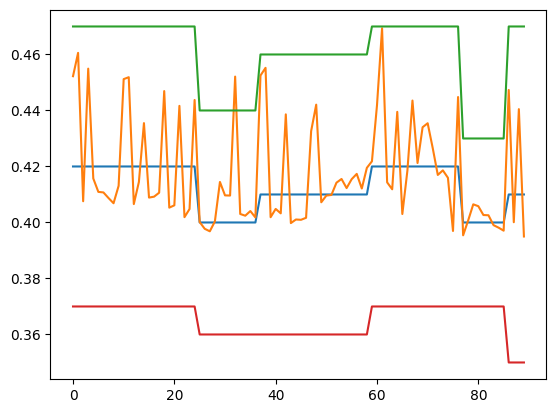

In [366]:
plt.plot(predict[:90])
plt.plot(data[:90])
plt.plot(max_arr[:90])
plt.plot(min_arr[:90])
plt.title()

In [360]:
max_arr

array([0.47, 0.47, 0.46, ..., 0.54, 0.54,  nan])

In [261]:
test_df.merge(predictions_df, on='MEAS_DT')

,MEAS_DT,Ni_1.1C_min,Ni_1.1C_max,Cu_1.1C_min,Cu_1.1C_max,Ni_1.2C_min,Ni_1.2C_max,Cu_1.2C_min,Cu_1.2C_max,Cu_2.1T_min,...,Ni_4.1T,Ni_4.2T,Ni_5.1C,Ni_5.2C,Ni_5.1T,Ni_5.2T,Ni_6.1C,Ni_6.2C,Ni_6.1T,Ni_6.2T
0,2024-01-19 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.681164,0.782092,6.388413,6.451944,0.729346,0.678733,8.710541,9.133474,1.162362,1.021844
1,2024-01-19 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.680491,0.803351,6.383918,6.421977,0.742186,0.677678,8.738028,9.107232,1.172715,1.045887
2,2024-01-19 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.666621,0.659945,6.316444,6.398043,0.686901,0.668141,8.671654,9.149901,1.117767,0.941940
3,2024-01-19 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.677324,0.789133,6.393485,6.463005,0.741143,0.675301,8.622660,9.057043,1.170564,1.022773
4,2024-01-19 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.660630,0.642323,6.322575,6.440649,0.673498,0.662884,8.555302,9.103427,1.136599,0.918613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6735,2024-11-05 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.721720,0.731563,6.449012,6.468097,0.611475,0.666549,8.871658,9.071485,1.687456,1.447973
6736,2024-11-05 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.722127,0.740255,6.425201,6.443622,0.611018,0.670435,8.874823,9.058571,1.696991,1.461697
6737,2024-11-05 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.719833,0.731813,6.465998,6.495482,0.612944,0.672198,8.863055,9.049041,1.669736,1.452280
6738,2024-11-05 18:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.720543,0.737228,6.445828,6.445376,0.613977,0.672218,8.812902,9.024268,1.656816,1.424029


In [255]:
concat_df['MEAS_DT']

0       2024-01-19 12:15:00
1       2024-01-19 12:30:00
2       2024-01-19 12:45:00
3       2024-01-19 13:00:00
4       2024-01-19 13:15:00
                ...        
30331   2024-11-11 22:45:00
30332   2024-11-11 23:00:00
30333   2024-11-11 23:15:00
30334   2024-11-11 23:30:00
30335   2024-11-11 23:45:00
Name: MEAS_DT, Length: 37076, dtype: datetime64[ns]

In [167]:
test_data_df = pd.concat([test_df, df], join='inner', axis=1)

In [168]:
test_data_df

,MEAS_DT,Ni_1.1C_min,Ni_1.1C_max,Cu_1.1C_min,Cu_1.1C_max,Ni_1.2C_min,Ni_1.2C_max,Cu_1.2C_min,Cu_1.2C_max,Cu_2.1T_min,...,Dens_1,Dens_2,Mass_3,FM_1.1_A,FM_1.2_A,FM_2.1_A,FM_2.2_A,FM_3.1_A,FM_3.2_A,Ni_rec
0,2024-01-19 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.388724,1.397016,1159.946120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-19 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.375562,1.397872,1189.409024,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2024-01-19 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.371214,1.399892,1247.048316,0.0,0.0,0.0,0.0,0.0,0.0,0.970170
3,2024-01-19 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.374260,1.408990,1323.884446,0.0,0.0,0.0,0.0,0.0,0.0,0.968639
4,2024-01-19 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.357874,1.414643,1295.851179,0.0,0.0,0.0,0.0,0.0,0.0,0.974205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6735,2024-11-05 17:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.349890,1.398969,1252.491040,0.0,1.0,0.0,0.0,0.0,0.0,0.948840
6736,2024-11-05 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.360473,1.393604,1255.261207,0.0,1.0,0.0,0.0,0.0,0.0,0.945517
6737,2024-11-05 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.370219,1.387483,1210.652368,0.0,1.0,0.0,0.0,0.0,0.0,0.949606
6738,2024-11-05 18:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.376571,1.383409,1194.522526,0.0,1.0,0.0,0.0,0.0,0.0,0.949933
